# Identifying News Chatter about lockdowns to identify useful news sources

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import numpy as np
import spacy
from collections import Counter
from newsapi import NewsApiClient

In [2]:
countries =  ['Germany', 'Italy','Brazil', 'France']
measures = {'lockdown': ['lockdown','imposed'],'schools_closing' : ['schools','corona','closed']}

In [3]:
def query_news(country, measure):
    # Init
    newsapi = NewsApiClient(api_key='29797838d37f4754a0dabf5da61d44d4')

    articles = list()

    query = country
    for w in measures[measure]:
        query += ' AND {}'.format(w)

    # We are greedy, take every news we can get until we reach the limit
    for n in range(1,9):
            try:
                headlines = newsapi.get_everything(q=query,language='en',from_param='2020-02-22',page=n)
                articles = articles + headlines['articles']
            except:
                break

    df = pd.DataFrame(articles)
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])

    return df

In [4]:
def find_words(df, dates):

    nlp = spacy.load("en_core_web_sm")
    word_dict = dict()

    for d in dates:
        day_df = find_articles_on_day(df,d)
        day_ct = Counter()

        for text in day_df['description']:
            if not text:
                continue
            
            doc = nlp(text)
            words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
            word_freq = Counter(words)

            day_ct += word_freq

        word_dict[d] = day_ct
    
    return word_dict

In [5]:
def find_articles_on_day(df, date):
    mask = (df['publishedAt'] >= date) & (df['publishedAt'] < date + timedelta(days = 1))
    return df[mask]

In [6]:
# Flawed Attempt trying to use the free Bing News API with less restriction. However, it has a strange selection of results which is difficult to tweak. Too painful.

# import time

# def query_news(country, measure):
#     query = country
    
#     for w in measures[measure]:
#         query += ' AND {}'.format(w)

#     subscription_key = "" # Fill in your Key
#     search_url = "https://api.cognitive.microsoft.com/bing/v7.0/news/search"
#     #search_url = "https://api.cognitive.microsoft.com/bing/v7.0/search"

#     headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

#     results = list()

#     for n in range(0,10):
#         params  = {'q': query, 'textFormat': "Raw", 'count':100, 'offset': n*100, 'freshness': 'Month', 'mkt':'en-US', 'setLang':'en', 'sortBy':'Date'}
#         response = requests.get(search_url, headers=headers, params=params)
#         response.raise_for_status()
#         search_results = response.json()

#         results = results + search_results['value']
#         time.sleep(1)

    
#     df = pd.DataFrame(results)
#     df['datePublished'] = pd.to_datetime(df['datePublished'])

#     return df

In [24]:
def plot_freq(df,ax,l=None):
    freqs_daily = df.resample('D', on='publishedAt').count()
    # Normalize to STDDEV, author is just a placeholder, could use any column
    freqs_daily['author'] = freqs_daily['author']/freqs_daily['author'].std()
    freqs_daily['author'].plot(grid=True,marker='o',ax=ax,label=l)

In [22]:
def find_likely_date(df,country):
    freqs_daily = df.resample('D', on='publishedAt').count()
    # Normalize to STDDEV, author is just a placeholder, could use any column
    freqs_daily['author'] = freqs_daily['author']/freqs_daily['author'].std()
    # Take 3 largest peaks
    peaks = np.argsort(freqs_daily['author'].tolist())[-3:]
    # Get their dates
    peaks_dates = freqs_daily['author'][peaks.tolist()]

    day_word_ct = find_words(df,peaks_dates.index)

    freq_daily_ct = dict()
    n = 0

    for d,ct in day_word_ct.items():
        n_words = ct[country]

        for w in measures['lockdown']:
            n_words += ct[w]

        if n < n_words:
            d_max = d
            n = n_words
            conf = freqs_daily.loc[d]['author']

    return d,conf

In [ ]:
def get_news_of_day(df,day):
    mask = (df['publishedAt'] >= day) & (df['publishedAt'] < day + timedelta(days = 1))
    df['source'] = df['source'].apply(lambda r : r['name'])
    return df[mask]

Text(0, 0.5, 'Frequency / StdDev')

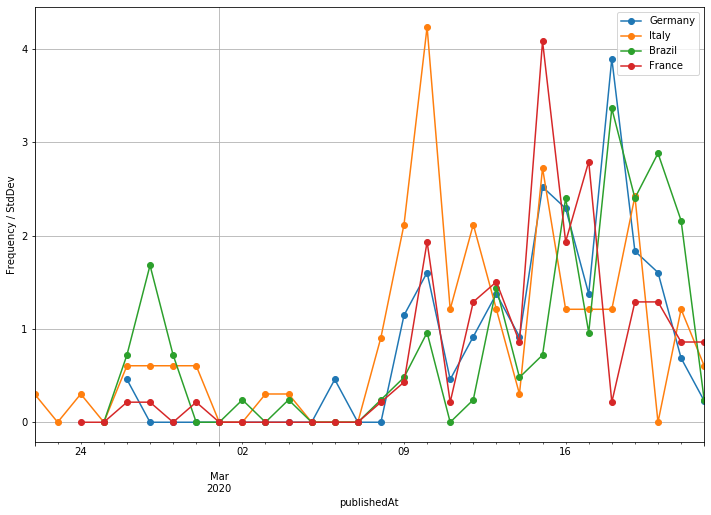

In [26]:
lockdowns = dict()

fig,ax = plt.subplots(figsize=(12,8))

for c in countries:
    df = query_news(c,'lockdown')
    d, conf = find_likely_date(df,c)
    plot_freq(df,ax,l=c)
    lockdowns[c] = {'day': d, 'conf': conf}

ax.legend()
ax.set_ylabel('Frequency / StdDev')

In [40]:
lock_df = pd.DataFrame(lockdowns).transpose()

In [41]:
lock_df

,day,conf
Germany,2020-03-18 00:00:00+00:00,2.52123
Italy,2020-03-10 00:00:00+00:00,4.23646
Brazil,2020-03-18 00:00:00+00:00,2.40172
France,2020-03-15 00:00:00+00:00,4.08298


In [36]:
lock_df.loc['Germany']

day     2020-03-18 00:00:00+00:00
conf                      2.52123
Name: Germany, dtype: object

In [48]:
test = find_articles_on_day(query_news('Italy','lockdown'),date=lock_df.loc['Italy']['day'])

In [49]:
test['source'] = test['source'].apply(lambda r : r['name'])
pd.set_option('display.max_colwidth', 2000)
test.drop(columns=['author','urlToImage','content'])

,source,title,description,url,publishedAt
1,CNN,This is what life is like under lockdown,Italy has imposed nationwide restrictions on 60 million residents as the number of coronavirus cases in the country continues to climb.,https://www.cnn.com/videos/world/2020/03/10/italy-lockdown-orig-london.cnn,2020-03-10 22:28:43+00:00
3,Mashable,Inside the red zone: Photos show dramatic impact of Italy's nationwide lockdown,"Approximately 60 million people in Italy are now under total lockdown in a desperate bid from the country's government to halt the spread of the new coronavirus (COVID-19). On Monday night, Prime Minister Giuseppe Conte announced severe measures for the entir…",https://mashable.com/article/italy-coronavirus-lockdown-quarantine/,2020-03-10 14:44:02+00:00
6,The Globe And Mail,All of Italy placed into lockdown after surge in COVID-19 infections and fatalities - The Globe and Mail,All of Italy placed into lockdown after surge in COVID-19 infections and fatalities The Globe and Mail Italy's PM placed the entire country on lockdown amid COVID-19 crisis - Business Insider Business Insider Italian premier locks down entire country to stop …,https://www.theglobeandmail.com/world/article-all-of-italy-placed-into-lockdown-after-surge-in-covid-19-infections/,2020-03-10 00:22:30+00:00
13,Yahoo.com,The Latest: Italy says supermarkets will remain open,Shoppers lined up overnight outside a Rome Carrefour to stock up after the government extended restrictions on movement from hard-hit northern Italy to the rest of the country. Pope Francis is urging priests to courageously go out to visit those sick from the…,https://news.yahoo.com/latest-cruise-ship-passengers-disembark-050405841.html,2020-03-10 05:04:05+00:00
15,BBC News,Coronavirus: Could the US do what Italy has done?,"Could the US lock down part, or even all, of its citizens to halt the spread of the deadly virus?",https://www.bbc.co.uk/news/world-us-canada-51804664,2020-03-10 17:01:42+00:00
18,Business Insider,Italians have been told they won't have to pay their mortgage payments while the country goes into coronavirus lockdown,"Mortgage payments will be suspended across the whole of Italy as the country struggles to deal with the coronavirus outbreak. Italy's coronavirus death toll jumped from 366 to 463 on Monday, making it the worst-hit country after China. The Italian government …",https://www.businessinsider.com/coronavirus-covid-19-italy-mortgage-payments-suspended-during-lockdown-2020-3,2020-03-10 12:30:00+00:00
20,Yahoo.com,Italy is in a nationwide lockdown over the coronavirus. Here are the rules all 60 million citizens now have to follow.,"The nationwide lockdown began Tuesday. Citizens now need police permission to travel, and businesses can open only if customers stay 3 feet apart.",https://news.yahoo.com/italy-complete-nationwide-lockdown-over-120135831.html,2020-03-10 12:01:35+00:00
27,Time,Why Is Italy’s Coronavirus Outbreak So Bad?,"In less than a month, Italy has gone from having only three cases of the coronavirus to having the highest number of cases and deaths outside of China",https://time.com/5799586/italy-coronavirus-outbreak/,2020-03-10 18:18:29+00:00
34,Time,China’s President Xi Jinping Makes First Visit to Coronavirus-Ravaged Wuhan,"State media reported Xi arrived in the morning in Wuhan, which has been under lockdown along with several nearby cities since late January",https://time.com/5799975/xi-jinping-wuhan-coronavirus/,2020-03-10 04:11:02+00:00
53,Indianexpress.com,Explained: Why Italy has imposed a nationwide lockdown,"Italy has enacted measures to clamp down movement and close public spaces. Quarantine measures that were already implemented in the northern Lombardy region, the country's richest, as well as in parts of neighbouring provinces, have now been expanded to the w…",https://indianexpress.com/article/explained/italy-coronavirus-cases-lockdown-6308192/,2020-03-10 13:41:31+00:00


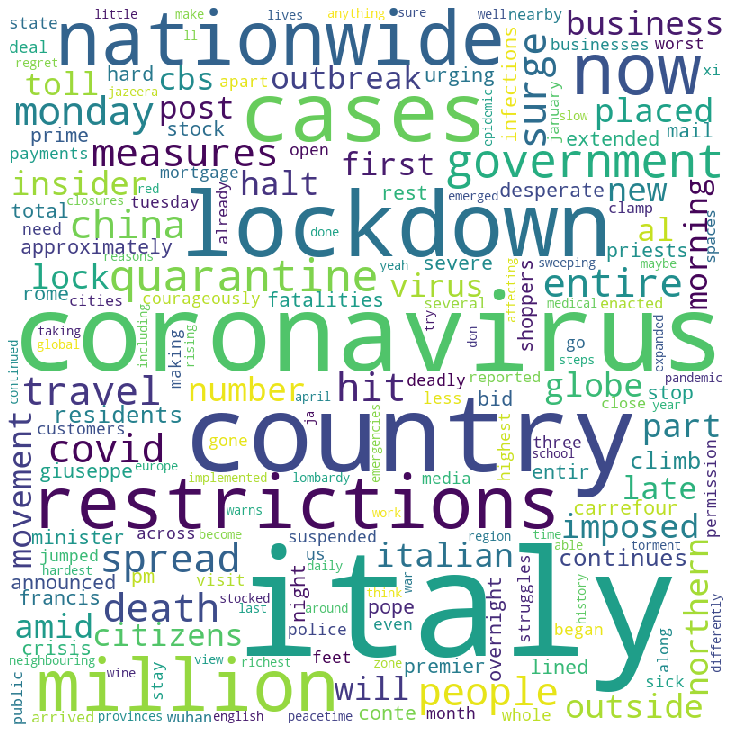

In [51]:
# Python program to generate WordCloud 
#https://www.geeksforgeeks.org/generating-word-cloud-python/

stopwords = set(STOPWORDS) 

comment_words = ' '

for val in test.description: 
    val = str(val) 
  
    # split the value 
    tokens = val.split()
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                       
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
